<a href="https://colab.research.google.com/github/yashc73080/CS462-Deep-Learning/blob/main/HW1/architecture_and_hyperparam_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt

Set the random seed

In [2]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Generating and Preparing Data

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Lambda(lambda x: x - 0.5)  # Shift to [-0.5, 0.5]
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True, pin_memory=True,
                          num_workers=0, persistent_workers=False)

test_loader = DataLoader(testset, batch_size=256, shuffle=False, pin_memory=True,
                         num_workers=0, persistent_workers=False)

Due to redundancy in all network classes, create a BaseNetwork class which will be inherited by the other networks

In [5]:
class BaseNetwork(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else device)
        # Initialize loss history tracking
        self.train_loss_history = []
        self.test_loss_history = []
        self.train_acc_history = []
        self.test_acc_history = []

    def forward(self, x):
        raise NotImplementedError

    def train_model(self, train_loader, test_loader=None, epochs=25, lr=0.1,
                    weight_decay=0.0, optimizer='sgd', verbose=True):
        self.loss_function = nn.CrossEntropyLoss()

        if optimizer.lower() == 'adam':
            self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            self.optimizer = optim.SGD(self.parameters(), lr=lr, weight_decay=weight_decay)

        # Clear previous history
        self.train_loss_history = []
        self.test_loss_history = []
        self.train_acc_history = []
        self.test_acc_history = []

        for epoch in range(epochs):
            self.train()  # Set model to training mode
            total_train_loss = 0.0
            correct_train = 0
            total_train = 0

            for x_batch, y_batch in train_loader:
                # Move to device
                x_batch = x_batch.to(self.device, non_blocking=True)
                y_batch = y_batch.to(self.device, non_blocking=True)

                # Forward pass
                logits = self.forward(x_batch)
                loss = self.loss_function(logits, y_batch)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Track metrics
                total_train_loss += loss.item() * x_batch.size(0)  # Weighted by batch size
                preds = torch.argmax(logits, dim=1)
                correct_train += (preds == y_batch).sum().item()
                total_train += y_batch.size(0)

            avg_train_loss = total_train_loss / total_train
            train_accuracy = correct_train / total_train
            self.train_loss_history.append(avg_train_loss)
            self.train_acc_history.append(train_accuracy)

            # Evaluate on test data
            if test_loader:
                avg_test_loss, test_accuracy = self.test_model(test_loader, verbose=False)
                self.test_loss_history.append(avg_test_loss)
                self.test_acc_history.append(test_accuracy)

                if verbose:
                    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, "
                          f"Train Acc: {train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, "
                          f"Test Acc: {test_accuracy:.4f}")
            else:
                if verbose:
                    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, "
                          f"Train Acc: {train_accuracy:.4f}")

        return avg_train_loss, train_accuracy

    def test_model(self, test_loader, verbose=True):
        self.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(self.device, non_blocking=True)
                y_batch = y_batch.to(self.device, non_blocking=True)

                logits = self.forward(x_batch)
                loss = self.loss_function(logits, y_batch)

                total_loss += loss.item() * x_batch.size(0)  # Weighted by batch size
                preds = torch.argmax(logits, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        avg_loss = total_loss / total
        accuracy = correct / total

        if verbose:
            print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

        return avg_loss, accuracy

    def plot_loss_history(self):
        """Plot training and test loss history"""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_history, 'b-', label='Training Loss')
        if self.test_loss_history:
            plt.plot(self.test_loss_history, 'r-', label='Test Loss')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(self.train_acc_history, 'b-', label='Training Accuracy')
        if self.test_acc_history:
            plt.plot(self.test_acc_history, 'r-', label='Test Accuracy')
        plt.title('Accuracy History')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def get_loss_history(self):
        return {
            'train_loss_history': self.train_loss_history.copy(),
            'test_loss_history': self.test_loss_history.copy(),
            'train_acc_history': self.train_acc_history.copy(),
            'test_acc_history': self.test_acc_history.copy()
        }

# 1. Basic Model

$F(\vec{x}) = \text{softmax}(A\vec{v}+\vec{b})$

In [11]:
class BasicModel(BaseNetwork):
  def __init__(self, input_size=784, output_size=10, device='cpu'):
    super().__init__(device=device)
    # Model parameters
    self.A = nn.Parameter(torch.randn(output_size, input_size, device=self.device), requires_grad=True) # shape (10, 784)
    self.b = nn.Parameter(torch.randn(output_size, device=self.device), requires_grad=True)  # shape (10,)

    self.to(self.device)

  def forward(self, x):
    logits = x @ self.A.t() + self.b # CrossEntropyLoss applies softmax internally
    return logits

  # train() and test() are inherited from BaseNetwork

In [ ]:
basic_model = BasicModel(input_size=784, output_size=10)
basic_train_loss, basic_train_acc = basic_model.train_model(train_loader, test_loader=None, epochs=350, lr=0.05)
basic_test_loss, basic_test_acc = basic_model.test_model(test_loader)

Epoch 1/350, Train Loss: 4.0855, Train Acc: 0.6572
Epoch 2/350, Train Loss: 1.6252, Train Acc: 0.8134
Epoch 3/350, Train Loss: 1.3113, Train Acc: 0.8392
Epoch 4/350, Train Loss: 1.1455, Train Acc: 0.8531
Epoch 5/350, Train Loss: 1.0363, Train Acc: 0.8603
Epoch 6/350, Train Loss: 0.9623, Train Acc: 0.8661


# 2. Fixed Size Layer Model

$\text{Parameters}(k,m)$ in terms of input size $n_{in}$, output size $n_{out}$, number of hidden layers $k$, and number of nodes per hidden layer $m$.

The following formula is the number of trainable parameters in the network. The full logic is in the report.
$$\text{Parameters}(k,m) = [(n_{in} \cdot m) + m] + [(k-1) \cdot (m \cdot m + m)] + [(m \cdot n_{out}) + n_{out}]$$

In [6]:
class FixedSizeNetwork(BaseNetwork):
  def __init__(self, input_size=784, output_size=10, num_layers=2, hidden_width=200, device='cpu'):
    '''
    Args:
      input_size (int): MNIST input size
      output_size (int): MNIST output size
      num_layers (int): Number of hidden layers (k)
      hidden_width (int): Width of hidden layers (m)
    '''
    super().__init__(device=device)

    # All layers of network
    layers = []

    # First layer (Input -> H1)
    layers.append(nn.Linear(input_size, hidden_width))
    layers.append(nn.Tanh())

    # Rest of the layers
    for _ in range(num_layers - 1):
      layers.append(nn.Linear(hidden_width, hidden_width))
      layers.append(nn.Tanh())

    # Wrap hidden layers
    self.hidden_layers = nn.Sequential(*layers)

    # Add output layer (Hk -> Output)
    self.output_layer = nn.Linear(hidden_width, output_size)

    # Move whole network to device
    self.to(self.device)

  def forward(self, x):
    # Flatten input
    x = x.view(x.size(0), -1)

    # Pass input through all hidden layers
    x = self.hidden_layers(x)

    # Pass through output layer
    logits = self.output_layer(x)

    return logits

  # train() and test() are inherited from BaseNetwork

Find the best combination of k and m

In [ ]:
def num_parameters(input_size=784, output_size=10, k=2, m=200):
    '''
    k = number of hidden layers
    m = width of hidden layers (number of nodes per hidden layer)
    '''
    input_H1 = (input_size * m) + m
    all_H = (k - 1) * (m * m + m)
    lastH_output = (m * output_size) + output_size
    return input_H1 + all_H + lastH_output

def get_m_for_k(k, P, n_in=784, n_out=10):
    if k == 1:
        # Simplified formula for k=1: P = (n_in + n_out)m + m + n_out
        # P = 794m + m + 10 = 795m + 10
        m = (P - n_out) / (n_in + 1 + n_out)
        return round(m)
    else:
        # Quadratic formula: am^2 + bm + c = 0
        a = k - 1
        b = k + n_in + n_out
        c = n_out - P

        # Calculate the discriminant
        discriminant = b**2 - 4*a*c

        if discriminant < 0:
            return None # No real solution for m

        # Solve for m (we only care about the positive root)
        m = (-b + np.sqrt(discriminant)) / (2 * a)
        return round(m)


In [ ]:
P_values = [100000, 250000, 500000]
k_to_test = [1, 2, 4, 6, 8, 10, 15, 20, 30, 50]

all_results = {}

# Loop through each budget
for P in P_values:
    print(f"--- Starting Experiment for P = {P} ---")

    # Store results for this specific P
    current_p_results = {'k': [], 'train_loss': [], 'test_loss': []}

    # Loop through each k value to test
    for k in k_to_test:
        # 4. Use helper functions to get the network width
        m = get_m_for_k(k, P)

        # Check if m is a valid width
        if m is None or m < 1:
            continue

        print(f"Testing shape: k={k}, m={m}")

        # Build and train network
        model = FixedSizeNetwork(num_layers=k, hidden_width=m, device=device)
        final_train_loss, _ = model.train(X_train, y_train, lr=0.1, epochs=25, verbose=False)
        final_test_loss, _ = model.test(X_test, y_test, verbose=False)

        # Save the results
        current_p_results['k'].append(k)
        current_p_results['train_loss'].append(final_train_loss)
        current_p_results['test_loss'].append(final_test_loss)


    all_results[P] = current_p_results

--- Starting Experiment for P = 100000 ---
Testing shape: k=1, m=126
Testing shape: k=2, m=110
Testing shape: k=4, m=93
Testing shape: k=6, m=82
Testing shape: k=8, m=75
Testing shape: k=10, m=70
Testing shape: k=15, m=60
Testing shape: k=20, m=54
Testing shape: k=30, m=46
Testing shape: k=50, m=37
--- Starting Experiment for P = 250000 ---
Testing shape: k=1, m=314
Testing shape: k=2, m=241
Testing shape: k=4, m=185
Testing shape: k=6, m=157
Testing shape: k=8, m=140
Testing shape: k=10, m=128
Testing shape: k=15, m=108
Testing shape: k=20, m=95
Testing shape: k=30, m=80
Testing shape: k=50, m=63
--- Starting Experiment for P = 500000 ---
Testing shape: k=1, m=629
Testing shape: k=2, m=413
Testing shape: k=4, m=296
Testing shape: k=6, m=246
Testing shape: k=8, m=216
Testing shape: k=10, m=195
Testing shape: k=15, m=162
Testing shape: k=20, m=142
Testing shape: k=30, m=118
Testing shape: k=50, m=93


In [ ]:
all_results

{100000: {'k': [1, 2, 4, 6, 8, 10, 15, 20, 30, 50],
  'train_loss': [0.03220911809452486,
   0.012854672407447768,
   0.013930081365290973,
   0.022384086952875484,
   0.035395530866707,
   0.04152257976086419,
   2.3231015200294323,
   2.304103593816116,
   2.304115903542925,
   2.304100004306089],
  'test_loss': [0.07381018996238708,
   0.07760341465473175,
   0.0963161289691925,
   0.12346938252449036,
   0.1254062056541443,
   0.12845772504806519,
   2.3116636276245117,
   2.3014230728149414,
   2.3014299869537354,
   2.3014276027679443]},
 250000: {'k': [1, 2, 4, 6, 8, 10, 15, 20, 30, 50],
  'train_loss': [0.030901679437430607,
   0.01250122751507748,
   0.009063573850056537,
   0.020110987735328698,
   0.02767379378434395,
   0.03554314835484834,
   0.0942358376998494,
   2.3041083227481254,
   2.3041118618772787,
   2.3041064136183502],
  'test_loss': [0.07349797338247299,
   0.07886622101068497,
   0.0920649990439415,
   0.10237722843885422,
   0.12100087851285934,
   0.1086959

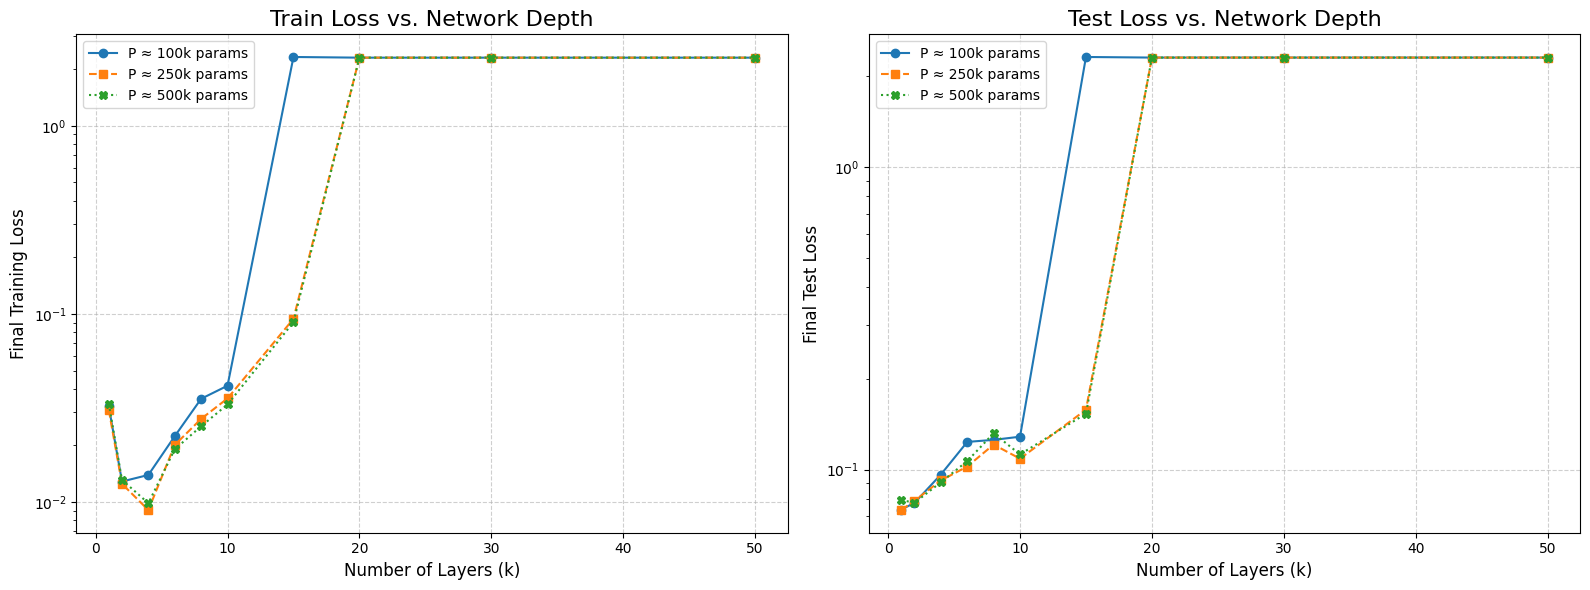

In [ ]:
# Plot training and testing loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define styles for each line to make them unique
styles = {
    100000: {'marker': 'o', 'linestyle': '-', 'color': 'C0'}, # Circle, solid, blue
    250000: {'marker': 's', 'linestyle': '--', 'color': 'C1'}, # Square, dashed, orange
    500000: {'marker': 'X', 'linestyle': ':', 'color': 'C2'}  # X, dotted, green
}

# Plot 1: Training Loss
ax1.set_title('Train Loss vs. Network Depth', fontsize=16)
ax1.set_xlabel('Number of Layers (k)', fontsize=12)
ax1.set_ylabel('Final Training Loss', fontsize=12)

# Loop through each parameter budget (P) in the results
for P, data in all_results.items():
    style = styles[P]
    # Plot k vs training loss for the current P
    ax1.plot(data['k'], data['train_loss'], marker=style['marker'], linestyle=style['linestyle'], color=style['color'], label=f'P ≈ {P/1000:.0f}k params')

ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_yscale('log')

# Plot 2: Test Loss
ax2.set_title('Test Loss vs. Network Depth', fontsize=16)
ax2.set_xlabel('Number of Layers (k)', fontsize=12)
ax2.set_ylabel('Final Test Loss', fontsize=12)

# Loop through each parameter budget (P) in the results
for P, data in all_results.items():
    style = styles[P]
    # Plot k vs test loss for the current P
    ax2.plot(data['k'], data['test_loss'], marker=style['marker'], linestyle=style['linestyle'], color=style['color'], label=f'P ≈ {P/1000:.0f}k params')

ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

Now building and training the network with optimized k and m

In [7]:
fixed_network = FixedSizeNetwork(input_size=784, output_size=10, num_layers=1, hidden_width=314) # k = num_layers, m = hidden_width
fixed_train_loss, fixed_train_acc = fixed_network.train_model(train_loader, epochs=25, lr=0.1)
fixed_test_loss, fixed_test_acc = fixed_network.test_model(test_loader)

Epoch 1/25, Train Loss: 0.4524, Train Acc: 0.8719
Epoch 2/25, Train Loss: 0.2956, Train Acc: 0.9136
Epoch 3/25, Train Loss: 0.2458, Train Acc: 0.9283
Epoch 4/25, Train Loss: 0.2013, Train Acc: 0.9417
Epoch 5/25, Train Loss: 0.1686, Train Acc: 0.9506
Epoch 6/25, Train Loss: 0.1451, Train Acc: 0.9579
Epoch 7/25, Train Loss: 0.1270, Train Acc: 0.9635
Epoch 8/25, Train Loss: 0.1129, Train Acc: 0.9678
Epoch 9/25, Train Loss: 0.1019, Train Acc: 0.9700
Epoch 10/25, Train Loss: 0.0915, Train Acc: 0.9739
Epoch 11/25, Train Loss: 0.0838, Train Acc: 0.9759
Epoch 12/25, Train Loss: 0.0776, Train Acc: 0.9771
Epoch 13/25, Train Loss: 0.0709, Train Acc: 0.9793
Epoch 14/25, Train Loss: 0.0654, Train Acc: 0.9810
Epoch 15/25, Train Loss: 0.0605, Train Acc: 0.9827
Epoch 16/25, Train Loss: 0.0561, Train Acc: 0.9840
Epoch 17/25, Train Loss: 0.0521, Train Acc: 0.9851
Epoch 18/25, Train Loss: 0.0495, Train Acc: 0.9859
Epoch 19/25, Train Loss: 0.0456, Train Acc: 0.9876
Epoch 20/25, Train Loss: 0.0430, Train A

# 3. Improving Architecture

In [ ]:
class FlexibleSizeNetwork(BaseNetwork):
  def __init__(self, input_size=784, output_size=10, hidden_layers=[], activation='tanh', device='cpu'):
    super().__init__(device=device)

    activation_functions = {
        'sigmoid': nn.Sigmoid(),
        'tanh': nn.Tanh(),
        'relu': nn.ReLU(),
        'elu': nn.ELU()
    }
    act_fn = activation_functions.get(activation.lower(), nn.Tanh())

    layers = []

    if hidden_layers:
      layers.append(nn.Linear(input_size, hidden_layers[0]))
      layers.append(act_fn)

      for i in range(len(hidden_layers) - 1):
        layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
        layers.append(act_fn)

      layers.append(nn.Linear(hidden_layers[-1], output_size))
    else:
      layers.append(nn.Linear(input_size, output_size))

    self.all_layers = nn.Sequential(*layers)
    self.to(self.device)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    return self.all_layers(x)

  # train() and test() are inherited from BaseNetwork

In [ ]:
hidden_configs = [
    [300, 300],
    [390, 260],
    [290, 310],
    [280, 220, 150],
    [250, 300, 200]
]
lr = 0.1
epochs = 25
print(f'Learning Rate: {lr}, Epochs: {epochs}')

for hidden_layers in hidden_configs:
  print(f'Starting run for hidden layers: {hidden_layers}')
  flex_network = FlexibleSizeNetwork(input_size=784, output_size=10, hidden_layers=hidden_layers, device=device)
  flex_train_loss, flex_train_acc = flex_network.train(X_train, y_train, epochs=25, lr=0.1, batch_size=64, verbose=False)
  flex_test_loss, flex_test_acc = flex_network.test(X_test, y_test, verbose=False)

  print(f'Final Train Loss: {flex_train_loss:.4f}, Final Train Accuracy: {flex_train_acc:.4f}')
  print(f'Final Test Loss: {flex_test_loss:.4f}, Final Test Accuracy: {flex_test_acc:.4f}')

Learning Rate: 0.1, Epochs: 25
Starting run for hidden layers: [300, 300]
Final Train Loss: 0.0129, Final Train Accuracy: 0.9925
Final Test Loss: 0.0768, Final Test Accuracy: 0.9778
Starting run for hidden layers: [390, 260]
Final Train Loss: 0.0137, Final Train Accuracy: 0.9945
Final Test Loss: 0.0768, Final Test Accuracy: 0.9771
Starting run for hidden layers: [290, 310]
Final Train Loss: 0.0129, Final Train Accuracy: 0.9928
Final Test Loss: 0.0819, Final Test Accuracy: 0.9760
Starting run for hidden layers: [280, 220, 150]
Final Train Loss: 0.0082, Final Train Accuracy: 0.9962
Final Test Loss: 0.0803, Final Test Accuracy: 0.9787
Starting run for hidden layers: [250, 300, 200]
Final Train Loss: 0.0080, Final Train Accuracy: 0.9955
Final Test Loss: 0.0827, Final Test Accuracy: 0.9782


Experimenting to see if weight decay can help

In [ ]:
flex_decay_network = FlexibleSizeNetwork(input_size=784, output_size=10, hidden_layers=[250, 300, 200], device=device)
decay_train_loss, decay_train_acc = flex_decay_network.train(X_train, y_train, epochs=25, lr=0.1, batch_size=64, weight_decay=1e-5, verbose=False)
decay_test_loss, decay_test_acc = flex_decay_network.test(X_test, y_test, verbose=False)

print(f'Final Train Loss: {decay_train_loss:.4f}, Final Train Accuracy: {decay_train_acc:.4f}')
print(f'Final Test Loss: {decay_test_loss:.4f}, Final Test Accuracy: {decay_test_acc:.4f}')

Final Train Loss: 0.0091, Final Train Accuracy: 0.9925
Final Test Loss: 0.0934, Final Test Accuracy: 0.9754


# 4. Training Effects

Optimizing batch size for BasicModel

In [ ]:
# Find all divisors of 60000
batch_sizes_to_test = []
for i in range(1, 60001):
    if 60000 % i == 0:
        batch_sizes_to_test.append(i)

print(f"Found {len(batch_sizes_to_test)} batch sizes to test.")

Found 60 batch sizes to test.


In [ ]:
learning_rates = [0.1, 0.05, 0.01]
all_batch_results = {}

for lr in learning_rates:
  print(f"Testing Learning Rate: {lr}")
  lr_results = {'batch_size': [], 'final_loss': []}

  for bs in batch_sizes_to_test:
    model = BasicModel(input_size=784, output_size=10, device=device)

    final_loss, _ = model.train(X_train, y_train, epochs=1, lr=lr, batch_size=bs, verbose=False)

    # Store results
    lr_results['batch_size'].append(bs)
    lr_results['final_loss'].append(final_loss)

  all_batch_results[lr] = lr_results

--- Testing Learning Rate: 0.1 ---
Testing batch size: 1
Testing batch size: 2
Testing batch size: 3
Testing batch size: 4
Testing batch size: 5
Testing batch size: 6
Testing batch size: 8
Testing batch size: 10
Testing batch size: 12
Testing batch size: 15
Testing batch size: 16
Testing batch size: 20
Testing batch size: 24
Testing batch size: 25
Testing batch size: 30
Testing batch size: 32
Testing batch size: 40
Testing batch size: 48
Testing batch size: 50
Testing batch size: 60
Testing batch size: 75
Testing batch size: 80
Testing batch size: 96
Testing batch size: 100
Testing batch size: 120
Testing batch size: 125
Testing batch size: 150
Testing batch size: 160
Testing batch size: 200
Testing batch size: 240
Testing batch size: 250
Testing batch size: 300
Testing batch size: 375
Testing batch size: 400
Testing batch size: 480
Testing batch size: 500
Testing batch size: 600
Testing batch size: 625
Testing batch size: 750
Testing batch size: 800
Testing batch size: 1000
Testing ba

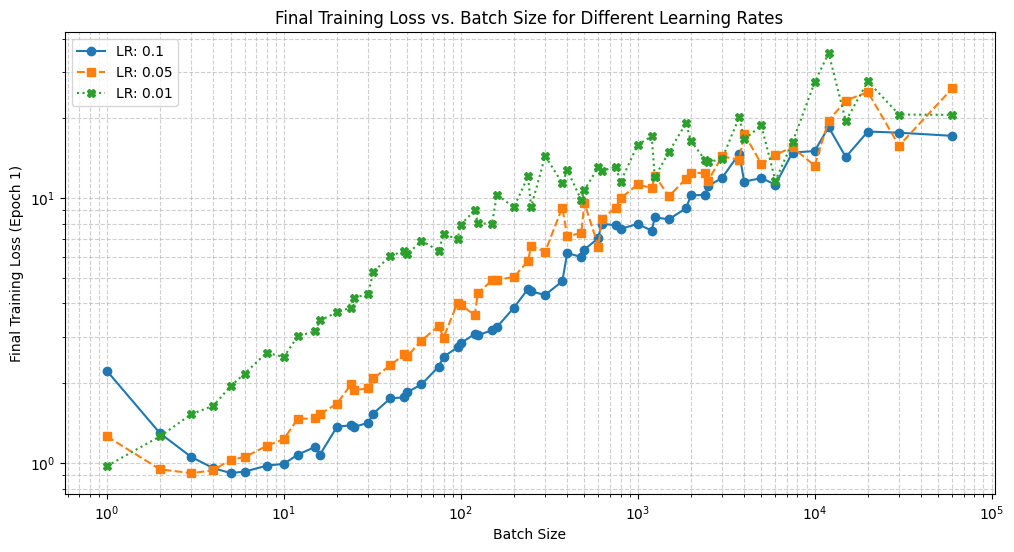

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))

# Define styles for each learning rate
styles = {
    0.1: {'marker': 'o', 'linestyle': '-', 'color': 'C0'},
    0.05: {'marker': 's', 'linestyle': '--', 'color': 'C1'},
    0.01: {'marker': 'X', 'linestyle': ':', 'color': 'C2'}
}

for lr, data in all_batch_results.items():
    style = styles[lr]
    plt.plot(data['batch_size'], data['final_loss'], marker=style['marker'], linestyle=style['linestyle'], color=style['color'], label=f'LR: {lr}')

plt.xlabel('Batch Size')
plt.ylabel('Final Training Loss (Epoch 1)')
plt.title('Final Training Loss vs. Batch Size for Different Learning Rates')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.show()

Experimenting with optimizer and activiation for FlexibleSizeNetwork

In [ ]:
optimizers = ['sgd', 'adam']
activations = ['sigmoid', 'tanh', 'relu', 'elu']
full_results = {}

for opt in optimizers:
  for act in activations:
    print(f"Testing Optimizer: {opt}, Activation: {act}")
    model = FlexibleSizeNetwork(input_size=784, output_size=10, hidden_layers=[250, 300, 200], activation=act, device=device)
    train_loss, _ = model.train(X_train, y_train, epochs=1, lr=0.05, batch_size=3, optimizer=opt, verbose=False)
    test_loss, _ = model.test(X_test, y_test, verbose=False)

    print(f"Final Train Loss: {train_loss:.4f}, Final Test Loss: {test_loss:.4f}")

    if opt not in full_results:
        full_results[opt] = {}
    full_results[opt][act] = {
        'train_loss': train_loss,
        'test_loss': test_loss
    }

Testing Optimizer: sgd, Activation: sigmoid
Final Train Loss: 2.2114, Final Test Loss: 1.7572
Testing Optimizer: sgd, Activation: tanh
Final Train Loss: 0.3741, Final Test Loss: 0.2421
Testing Optimizer: sgd, Activation: relu
Final Train Loss: 0.3666, Final Test Loss: 0.2839
Testing Optimizer: sgd, Activation: elu
Final Train Loss: 0.3937, Final Test Loss: 0.2456
Testing Optimizer: adam, Activation: sigmoid
Final Train Loss: 4.2197, Final Test Loss: 3.1576
Testing Optimizer: adam, Activation: tanh
Final Train Loss: 6.7185, Final Test Loss: 4.6988
Testing Optimizer: adam, Activation: relu
Final Train Loss: 2.3645, Final Test Loss: 2.3048
Testing Optimizer: adam, Activation: elu
Final Train Loss: 6.6227, Final Test Loss: 5.4453


In [ ]:
import pandas as pd

data = []
for optimizer, activations in full_results.items():
    for activation, losses in activations.items():
        data.append({'Optimizer': optimizer, 'Activation': activation, 'Train Loss': losses['train_loss'], 'Test Loss': losses['test_loss']})

df = pd.DataFrame(data)
display(df)

,Optimizer,Activation,Train Loss,Test Loss
0,sgd,sigmoid,2.211411,1.757226
1,sgd,tanh,0.374073,0.242148
2,sgd,relu,0.366630,0.283933
3,sgd,elu,0.393658,0.245569
4,adam,sigmoid,4.219674,3.157607
5,adam,tanh,6.718481,4.698820
6,adam,relu,2.364481,2.304824
7,adam,elu,6.622661,5.445289


# 5. CNNs vs Dense Networks

In [ ]:
class ConvNetwork(BaseNetwork):
  def __init__(self, conv_layers_config, dense_layers_config, input_shape=(1,28,28), output_size=10, device='cpu'):
    '''
    Args:
      conv_layers_config (list of tuples): Tuples of (output_channels, kernel_size)
      dense_layers_config (list of ints): List of number of neurons per layer
    '''
    super().__init__(device=device)
    self.input_shape = input_shape

    # Build convolutional layers
    conv_layers = []
    in_channels = input_shape[0]
    for out_channels, kernel_size in conv_layers_config:
      conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride=(1, 1)))
      conv_layers.append(nn.Tanh())
      in_channels = out_channels
    self.conv_layers = nn.Sequential(*conv_layers)

    # Get size of flattened layer for any config
    with torch.no_grad():
      test_input = torch.zeros(1, *self.input_shape)
      test_output = self.conv_layers(test_input)
      self._flattened_size = test_output.numel()

    # Build dense layers
    dense_layers = []
    in_features = self._flattened_size
    for hidden_size in dense_layers_config:
      dense_layers.append(nn.Linear(in_features, hidden_size))
      dense_layers.append(nn.Tanh())
      in_features = hidden_size
    dense_layers.append(nn.Linear(in_features, output_size))
    self.dense_layers = nn.Sequential(*dense_layers)

    self.to(self.device)

  def forward(self, x):
    # BaseNetwork flattens image to (batch_size, 784), reshape to 2D image (batch_size, 1, 28, 28)
    x = x.view(x.size(0), *self.input_shape)
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    logits = self.dense_layers(x)
    return logits

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

Epoch 1/20, Training Loss: 0.2886, Test Loss: 0.1753
Epoch 2/20, Training Loss: 0.1403, Test Loss: 0.1246
Epoch 3/20, Training Loss: 0.1034, Test Loss: 0.1042
Epoch 4/20, Training Loss: 0.0819, Test Loss: 0.0929
Epoch 5/20, Training Loss: 0.0664, Test Loss: 0.0859
Epoch 6/20, Training Loss: 0.0546, Test Loss: 0.0801
Epoch 7/20, Training Loss: 0.0448, Test Loss: 0.0762
Epoch 8/20, Training Loss: 0.0368, Test Loss: 0.0737
Epoch 9/20, Training Loss: 0.0302, Test Loss: 0.0714
Epoch 10/20, Training Loss: 0.0249, Test Loss: 0.0692
Epoch 11/20, Training Loss: 0.0207, Test Loss: 0.0674
Epoch 12/20, Training Loss: 0.0173, Test Loss: 0.0663
Epoch 13/20, Training Loss: 0.0146, Test Loss: 0.0651
Epoch 14/20, Training Loss: 0.0124, Test Loss: 0.0644
Epoch 15/20, Training Loss: 0.0107, Test Loss: 0.0639
Epoch 16/20, Training Loss: 0.0092, Test Loss: 0.0636
Epoch 17/20, Training Loss: 0.0081, Test Loss: 0.0631
Epoch 18/20, Training Loss: 0.0071, Test Loss: 0.0625
Epoch 19/20, Training Loss: 0.0063, T

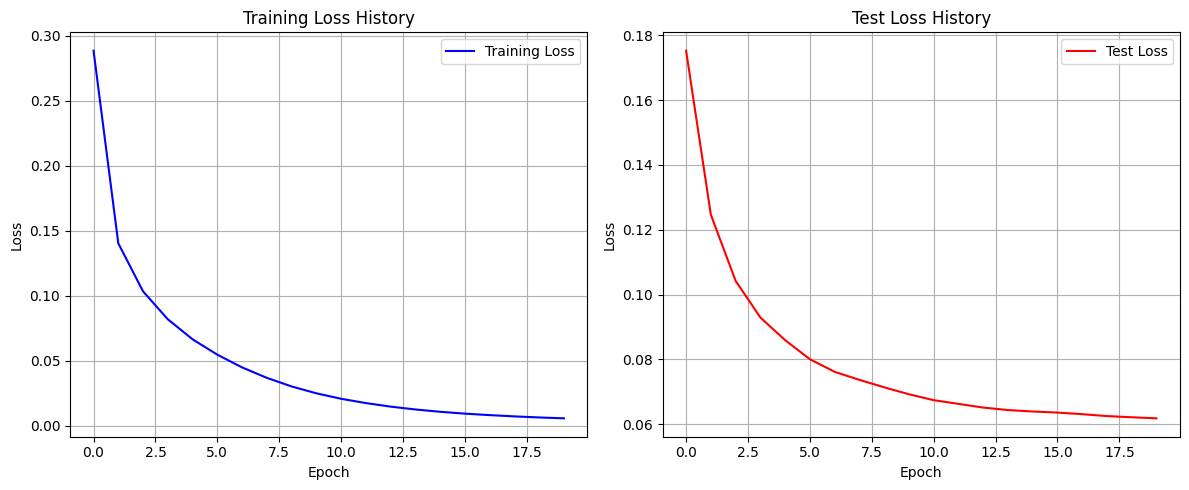

In [ ]:
cnn_1 = ConvNetwork(
    conv_layers_config=[(16,5)],
    dense_layers_config=[64],
    input_shape=(1,28,28),
    output_size=10,
    device=device
)
cnn_1_train_loss, cnn_1_train_acc = cnn_1.train(X_train, y_train, X_test=X_test, y_test=y_test, epochs=20, lr=0.1, batch_size=64)
cnn_1_test_loss, cnn_1_test_acc = cnn_1.test(X_test, y_test)
cnn_1.plot_loss_history()

Epoch 1/20, Training Loss: 0.5154, Test Loss: 0.2864
Epoch 2/20, Training Loss: 0.2584, Test Loss: 0.2189
Epoch 3/20, Training Loss: 0.1965, Test Loss: 0.1899
Epoch 4/20, Training Loss: 0.1574, Test Loss: 0.1718
Epoch 5/20, Training Loss: 0.1305, Test Loss: 0.1556
Epoch 6/20, Training Loss: 0.1108, Test Loss: 0.1420
Epoch 7/20, Training Loss: 0.0955, Test Loss: 0.1325
Epoch 8/20, Training Loss: 0.0830, Test Loss: 0.1241
Epoch 9/20, Training Loss: 0.0725, Test Loss: 0.1141
Epoch 10/20, Training Loss: 0.0633, Test Loss: 0.1057
Epoch 11/20, Training Loss: 0.0555, Test Loss: 0.1013
Epoch 12/20, Training Loss: 0.0487, Test Loss: 0.0978
Epoch 13/20, Training Loss: 0.0433, Test Loss: 0.0929
Epoch 14/20, Training Loss: 0.0378, Test Loss: 0.0898
Epoch 15/20, Training Loss: 0.0334, Test Loss: 0.0884
Epoch 16/20, Training Loss: 0.0293, Test Loss: 0.0846
Epoch 17/20, Training Loss: 0.0255, Test Loss: 0.0832
Epoch 18/20, Training Loss: 0.0221, Test Loss: 0.0834
Epoch 19/20, Training Loss: 0.0192, T

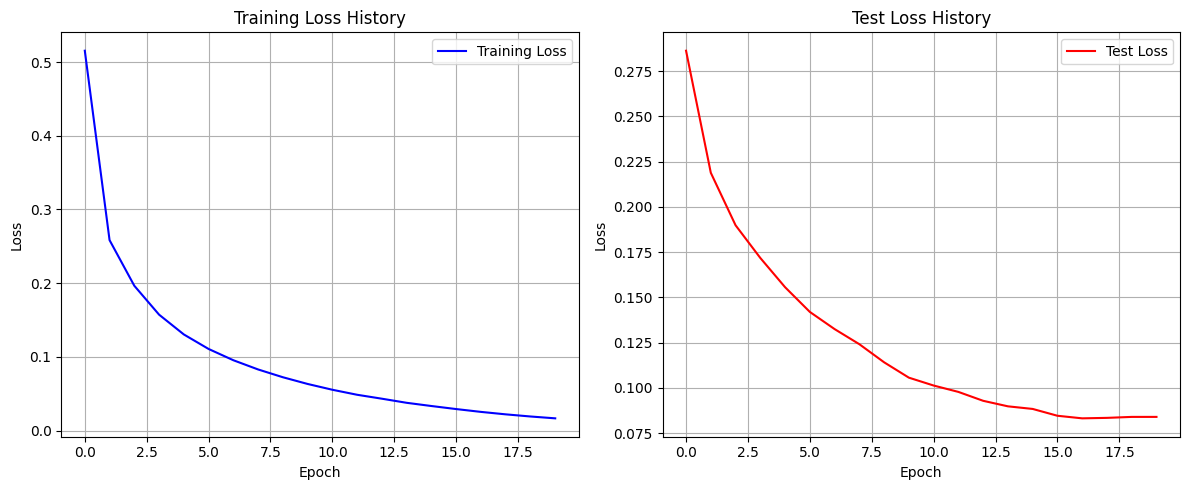

In [ ]:
orig_dense_network = FlexibleSizeNetwork(input_size=784, output_size=10, hidden_layers=[250, 300, 200], device=device)
orig_train_loss, orig_train_acc = orig_dense_network.train(X_train, y_train, X_test=X_test, y_test=y_test, epochs=20, lr=0.1, batch_size=64)
orig_test_loss, orig_test_loss = orig_dense_network.test(X_test, y_test)
orig_dense_network.plot_loss_history()

In [ ]:
cnn_2 = ConvNetwork(
    conv_layers_config=[(16,5), (8,5)],
    dense_layers_config=[64],
    input_shape=(1,28,28),
    output_size=10,
    device=device
)
cnn_2_train_loss, cnn_2_train_acc = cnn_2.train(X_train, y_train, epochs=20, lr=0.1, batch_size=64)
cnn_2_test_loss, cnn_2_test_acc = cnn_2.test(X_test, y_test)

Epoch 1/20, Training Loss: 0.2541
Epoch 2/20, Training Loss: 0.1017
Epoch 3/20, Training Loss: 0.0672
Epoch 4/20, Training Loss: 0.0482
Epoch 5/20, Training Loss: 0.0358
Epoch 6/20, Training Loss: 0.0265
Epoch 7/20, Training Loss: 0.0198
Epoch 8/20, Training Loss: 0.0151
Epoch 9/20, Training Loss: 0.0118
Epoch 10/20, Training Loss: 0.0094
Epoch 11/20, Training Loss: 0.0076
Epoch 12/20, Training Loss: 0.0063
Epoch 13/20, Training Loss: 0.0053
Epoch 14/20, Training Loss: 0.0045
Epoch 15/20, Training Loss: 0.0039
Epoch 16/20, Training Loss: 0.0034
Epoch 17/20, Training Loss: 0.0031
Epoch 18/20, Training Loss: 0.0028
Epoch 19/20, Training Loss: 0.0025
Epoch 20/20, Training Loss: 0.0023
Final Train Loss: 0.0023, Final Train Accuracy: 0.9997
Test Loss: 0.0441, Test Accuracy: 0.9868


In [ ]:
print(f'CNN 1 has {count_parameters(cnn_1)} parameters')
print(f'CNN 2 has {count_parameters(cnn_2)} parameters')
print(f'Dense Network has {count_parameters(orig_dense_network)} parameters')

CNN 1 has 590954 parameters
CNN 2 has 209138 parameters
Dense Network has 333760 parameters
